In [ ]:
!nvidia-smi

Sun Jan 19 14:47:08 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   51C    P8              17W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!kill -9 <PID>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `kill -9 <PID>'


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
!pip install numpy
!pip install torch
!pip install -U bitsandbytes
!pip install transformers peft unsloth datasets accelerate
!pip install bert-score rouge-score
!pip install evaluate

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training

# Define the quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type="nf4",  # Use NormalFloat4 quantization type
    bnb_4bit_compute_dtype=torch.float16,  # Use float16 for computation
    bnb_4bit_use_double_quant=True,  # Enable double quantization
)

# Load the model with quantization
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    device_map="auto",
    quantization_config=bnb_config,  # Pass the quantization configuration
    trust_remote_code=True,
)

# Prepare the model for k-bit training
model = prepare_model_for_kbit_training(model)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Apply QLoRA adapters
from peft import LoraConfig, get_peft_model

def apply_qlora_adapters(base_model):
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        target_modules=["self_attn.qkv_proj", "mlp.gate_up_proj", "mlp.down_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )

    lora_model = get_peft_model(base_model, lora_config)
    return lora_model

# Apply QLoRA to the quantized model
lora_model = apply_qlora_adapters(model)

In [ ]:
lora_model.print_trainable_parameters()

trainable params: 11,010,048 || all params: 3,832,089,600 || trainable%: 0.2873


In [ ]:
# Load data
from transformers import AutoTokenizer
from datasets import load_dataset
import pandas as pd

# Load tokenizer and dataset
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")
dataset = load_dataset("soumakchak/earnings_call_dataset")

train_set = dataset["train"]
valid_set = dataset["validation"]
test_set = dataset["test"]

train_df = train_set.to_pandas()
valid_df = valid_set.to_pandas()
test_df = test_set.to_pandas()

print("First few samples from the training set:")
print(train_df.head())
print("First few samples from the validation set:")
print(valid_df.head())
print("First few samples from the test set:")
print(test_df.head())

First few samples from the training set:
                                            document  \
0  For those of you that have not, it is availabl...   
1  I'm joined by Tom Greco, our President and Chi...   
2  I am joined by Tom Greco, our President and Ch...   
3  I'm joined today by Tom Greco, our President a...   
4  Both are now available on the Investors sectio...   

                                             summary  
0  q1 revenue rose 11.1 percent to $481.1 million...  
1  q1 adjusted earnings per share $3.34.\nq1 sale...  
2  advance auto parts q2 adjusted earnings per sh...  
3  compname reports q3 adjusted earnings per shar...  
4  withdrew its full year 2020 guidance that was ...  
First few samples from the validation set:
                                            document  \
0  Total revenue was approximately $1.5 billion, ...   
1  Regarding today's program, we will first revie...   
2  Factors, to our Annual Report on Form 10-K for...   
3  References to margins 

In [ ]:
# Compute token lengths
def compute_length(example):
    example["token_length"] = len(tokenizer(example["document"], truncation=False)["input_ids"])
    return example

# Add token length column to each split
train_with_lengths = dataset["train"].map(compute_length)
validation_with_lengths = dataset["validation"].map(compute_length)
test_with_lengths = dataset["test"].map(compute_length)

# Extract lengths for analysis
train_documents = train_with_lengths["document"]
validation_documents = validation_with_lengths["document"]
test_documents = test_with_lengths["document"]

train_lengths = train_with_lengths["token_length"]
validation_lengths = validation_with_lengths["token_length"]
test_lengths = test_with_lengths["token_length"]

# Create DataFrames for better readability
train_analysis = pd.DataFrame({
    "Document": train_documents,
    "Token Length": train_lengths
})
validation_analysis = pd.DataFrame({
    "Document": validation_documents,
    "Token Length": validation_lengths
})
test_analysis = pd.DataFrame({
    "Document": test_documents,
    "Token Length": test_lengths
})

# Displaying a summary of the token lengths for each set
train_analysis_summary = train_analysis.describe()
validation_analysis_summary = validation_analysis.describe()
test_analysis_summary = test_analysis.describe()

print(f"Train Analysis Summary:", train_analysis_summary)
print(f"Validation Analysis Summary:", validation_analysis_summary)
print(f"Test Analysis Summary:", test_analysis_summary)

Train Analysis Summary:        Token Length
count   1681.000000
mean    4292.563355
std     1577.496582
min      334.000000
25%     3221.000000
50%     4159.000000
75%     5256.000000
max    16367.000000
Validation Analysis Summary:        Token Length
count    249.000000
mean    4167.309237
std     1555.165624
min     1212.000000
25%     3066.000000
50%     4066.000000
75%     5044.000000
max    13207.000000
Test Analysis Summary:        Token Length
count    495.000000
mean    4241.676768
std     1626.456332
min      682.000000
25%     3156.000000
50%     4091.000000
75%     5150.000000
max    12940.000000


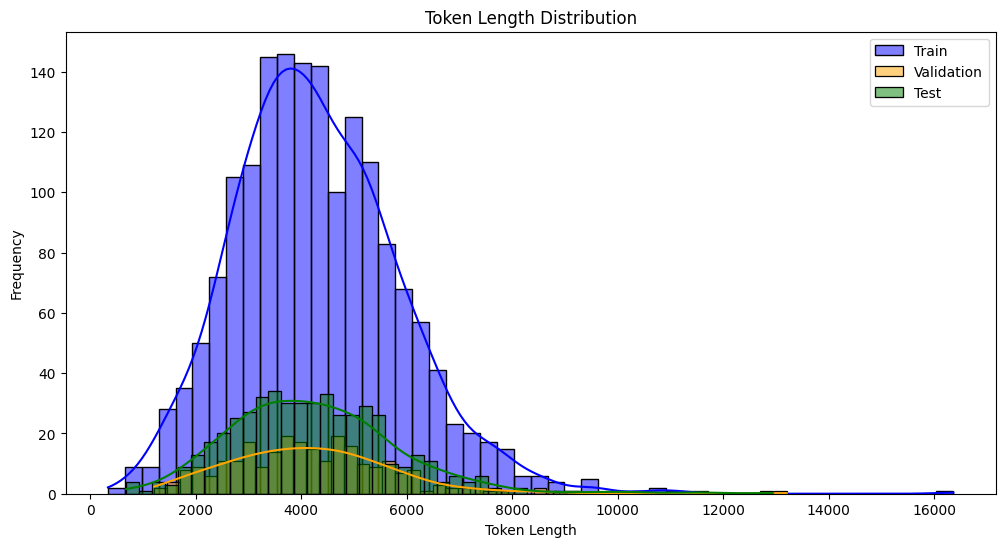

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract lengths for visualization
train_lengths = train_with_lengths["token_length"]
validation_lengths = validation_with_lengths["token_length"]
test_lengths = test_with_lengths["token_length"]

# Plotting the length distributions
plt.figure(figsize=(12, 6))
sns.histplot(train_lengths, bins=50, color='blue', label='Train', kde=True)
sns.histplot(validation_lengths, bins=50, color='orange', label='Validation', kde=True)
sns.histplot(test_lengths, bins=50, color='green', label='Test', kde=True)
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset

# Load dataset
dataset = load_dataset("soumakchak/earnings_call_dataset")

# Define the maximum token length
max_length = 2048

# Filter documents
def filter_documents(example):
    tokenized_length = len(tokenizer(example["document"], truncation=False)["input_ids"])
    return tokenized_length <= max_length

filtered_train = dataset["train"].filter(filter_documents)
filtered_validation = dataset["validation"].filter(filter_documents)
filtered_test = dataset["test"].filter(filter_documents)

In [ ]:
print(f"Filtered training set size: {len(filtered_train)}")
print(f"Filtered validation set size: {len(filtered_validation)}")
print(f"Filtered test set size: {len(filtered_test)}")

# Verify the longest document
max_train_length = max(
    len(tokenizer(doc, truncation=False)["input_ids"]) for doc in filtered_train["document"]
)
print(f"Longest document in the training set: {max_train_length} tokens")

# Verify the longest document in the test set
max_test_length = max(
    len(tokenizer(doc, truncation=False)["input_ids"]) for doc in filtered_test["document"]
)
print(f"Longest document in the test set: {max_test_length} tokens")

Filtered training set size: 101
Filtered validation set size: 18
Filtered test set size: 32
Longest document in the training set: 2037 tokens
Longest document in the test set: 2026 tokens


In [ ]:
print(filtered_train[10])
print(filtered_validation[10])
print(filtered_test[10])

{'document': "Actual results could differ materially due to the factors noted on these slides and in our periodic SEC filings.\nWe'll also refer to some non-GAAP financial measures today, which we believe help to facilitate comparisons across periods and with our peers.\nFor any non-GAAP measures we reference, we provide a reconciliation to the nearest corresponding GAAP measure.\nLet me start out by saying that the third quarter was a clear demonstration of us walking the talk.\nTop-line production exceeded recently increased guidance with productivity gains from both new and existing wells in the Permian Basin.\nThis outperformance dropped directly to strong bottom-line free cash flow as operating expenses and capital continue to benefit from our focus on best practices and realized efficiencies.\nCapital spending for the quarter came in at $115 million, below the bottom end of guidance, which was also lowered with the recent guidance update.\nOur operations team made strides on nume

In [ ]:
# Prepare prompts
def prepare_messages(example):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant that summarizes earnings call documents. Your task is to perform abstractive summarization on the given text. Always include performance-related numbers and key metrics in your summarization. Summarize the text in a few short and concise sentences, focusing on the most important information. Always start your summary with 'Sure! Here is the summary:\n'.",
        },
        {
            "role": "user",
            "content": f"Summarise the following text: {example['document']}",  # Insert the document into the user's message
        },
        {
            "role": "assistant",
            "content": f"Sure! Here is the summary:\n {example['summary']}",  # Include the summary as the assistant's response
        },
    ]
    return {"messages": messages}

In [ ]:
print(prepare_messages(filtered_train[0]))

{'messages': [{'role': 'system', 'content': "You are a helpful assistant that summarizes earnings call documents. Your task is to perform abstractive summarization on the given text. Always include performance-related numbers and key metrics in your summarization. Summarize the text in a few short and concise sentences, focusing on the most important information. Always start your summary with 'Sure! Here is the summary:\n'."}, {'role': 'user', 'content': "Summarise the following text: As you may recall, on our Q2 call in July, we were still somewhat apprehensive as we had just surpassed last year's COVID-impacted leasing velocity and the emerging Delta variant was creating uncertainty around universities plans to move forward with in-person classes and a return of campus social activities.\nAt that time, based on historical leasing velocity data, we continued to believe that the industry's COVID recovery would not fully materialize until the fall of 2022.\nToday, just three months lat

In [ ]:
# Process Datasets
from datasets import Dataset
from tqdm.auto import tqdm

def process_dataset(dataset):
    processed_examples = []
    for i in range(len(dataset)):
        processed_example = prepare_messages(dataset[i])
        processed_examples.append(processed_example)
    return processed_examples

processed_train = process_dataset(filtered_train)
processed_validation = process_dataset(filtered_validation)
processed_test = process_dataset(filtered_test)

In [ ]:
print(processed_train[0])

{'messages': [{'role': 'system', 'content': "You are a helpful assistant that summarizes earnings call documents. Your task is to perform abstractive summarization on the given text. Always include performance-related numbers and key metrics in your summarization. Summarize the text in a few short and concise sentences, focusing on the most important information. Always start your summary with 'Sure! Here is the summary:\n'."}, {'role': 'user', 'content': "Summarise the following text: As you may recall, on our Q2 call in July, we were still somewhat apprehensive as we had just surpassed last year's COVID-impacted leasing velocity and the emerging Delta variant was creating uncertainty around universities plans to move forward with in-person classes and a return of campus social activities.\nAt that time, based on historical leasing velocity data, we continued to believe that the industry's COVID recovery would not fully materialize until the fall of 2022.\nToday, just three months lat

In [ ]:
lora_model.gradient_checkpointing_enable()

In [ ]:
# Filter the dataset to get valid samples
def is_valid_example(example, tokenizer, max_length=2048):
    messages = example['messages']
    assistant_message = None
    for message in messages:
        if message['role'].lower() == 'assistant':
            assistant_message = message['content']
            break
    if assistant_message is None or assistant_message.strip() == '':
        return False

    # Serialize the conversation up to the assistant's message
    pre_assistant_conversation = ''
    for message in messages:
        if message['role'].lower() == 'assistant':
            break
        role = message['role']
        content = message['content']
        pre_assistant_conversation += f"{role}:\n{content}\n"

    # Tokenize the pre-assistant conversation
    pre_assistant_tokens = tokenizer(
        pre_assistant_conversation,
        truncation=True,
        max_length=max_length,
        padding=False,
        return_tensors='pt',
    )['input_ids'][0]

    assistant_tokens = tokenizer(
        assistant_message,
        truncation=True,
        max_length=max_length,
        padding=False,
        return_tensors='pt',
    )['input_ids'][0]

    # Create labels
    labels = [-100] * len(pre_assistant_tokens) + assistant_tokens.tolist()
    labels = labels[:max_length]

    # Check if there are any valid labels
    if all(label == -100 for label in labels):
        return False

    return True

In [ ]:
from datasets import Dataset

# Filter training, validation and test sets
valid_train_examples = [
    example for example in processed_train
    if is_valid_example(example, tokenizer)
]

valid_test_examples = [
    example for example in processed_test
    if is_valid_example(example, tokenizer)
]

valid_validation_examples = [
    example for example in processed_validation
    if is_valid_example(example, tokenizer)
]

print(f"Original training set size: {len(processed_train)}")
print(f"Filtered training set size: {len(valid_train_examples)}")

print(f"Original test set size: {len(processed_test)}")
print(f"Filtered test set size: {len(valid_test_examples)}")

print(f"Original validation set size: {len(processed_validation)}")
print(f"Filtered validation set size: {len(valid_validation_examples)}")

# Create new Datasets with the filtered examples
filtered_train_dataset = valid_train_examples
filtered_test_dataset = valid_test_examples
filtered_eval_dataset = valid_validation_examples

Original training set size: 101
Filtered training set size: 85
Original test set size: 32
Filtered test set size: 24
Original validation set size: 18
Filtered validation set size: 16


In [ ]:
# Prepare input data for fine-tuning
def data_collator(features):
    input_ids_list = []
    labels_list = []

    for feature in features:
        messages = feature['messages']

        # Serialize messages into a single string
        conversation = ''
        for message in messages:
            role = message['role']
            content = message['content']
            conversation += f"{role}:\n{content}\n"

        # Tokenize the entire conversation at once
        inputs = tokenizer(
            conversation,
            truncation=True,
            max_length=2048,
            padding=False,
            return_tensors='pt',
        )

        input_ids = inputs['input_ids'][0]

        # Find the assistant's message position
        assistant_index = None
        for idx, message in enumerate(messages):
            if message['role'].lower() == 'assistant':
                assistant_index = idx
                break

        if assistant_index is None:
            raise ValueError("Assistant's message not found in the conversation.")

        # Tokenize the conversation up to the assistant's message
        pre_assistant_conversation = ''
        for message in messages[:assistant_index]:
            role = message['role']
            content = message['content']
            pre_assistant_conversation += f"{role}:\n{content}\n"

        assistant_token_start = len(
            tokenizer(pre_assistant_conversation, truncation=True, max_length=2048, padding=False, return_tensors='pt')["input_ids"][0]
        )

        # Create labels: Mask input tokens, keep assistant's response tokens
        labels = [-100] * assistant_token_start + input_ids[assistant_token_start:].tolist()
        labels = labels[:2048]  # Ensure labels are within max length

        # Append to lists
        input_ids_list.append(input_ids)
        labels_list.append(torch.tensor(labels))

    # Pad sequences
    input_ids_padded = torch.nn.utils.rnn.pad_sequence(
        input_ids_list, batch_first=True, padding_value=tokenizer.pad_token_id
    )
    labels_padded = torch.nn.utils.rnn.pad_sequence(
        labels_list, batch_first=True, padding_value=-100
    )

    attention_mask_padded = input_ids_padded != tokenizer.pad_token_id

    batch = {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'labels': labels_padded,
    }

    return batch

In [ ]:
# Define the training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./fine-tuned-model',
    num_train_epochs=10,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    evaluation_strategy='steps',   # Evaluate every `eval_steps`
    eval_steps=10,
    save_strategy='steps',
    save_steps=10,                 # Save checkpoints every 10 steps
    logging_strategy='steps',      # Log every `logging_steps`
    logging_steps=1,               # Log every step
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=True,
    dataloader_num_workers=4,
    gradient_accumulation_steps=8,
    save_total_limit=2,
    remove_unused_columns=False,
    logging_first_step=True,       # Log the first step
    report_to="none",
    load_best_model_at_end=True,  # Load the best model
    metric_for_best_model="eval_loss",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # Stops after 3 evaluations with no improvement
    early_stopping_threshold=0.01,  # Minimum change to qualify as an improvement
)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=filtered_train_dataset,
    eval_dataset=filtered_eval_dataset,
    data_collator=data_collator,
    callbacks=[early_stopping],
)

In [ ]:
import os
os.environ["WANDB_MODE"] = "disabled"

In [ ]:
# Test with a training sample
train_sample = filtered_train_dataset[0]
train_batch = data_collator([train_sample])
print("Training batch input_ids shape:", train_batch["input_ids"].shape)
print("Training batch labels shape:", train_batch["labels"].shape)

# Test with a validation sample
val_sample = filtered_eval_dataset[0]
val_batch = data_collator([val_sample])
print("Validation batch input_ids shape:", val_batch["input_ids"].shape)
print("Validation batch labels shape:", val_batch["labels"].shape)

Training batch input_ids shape: torch.Size([1, 1939])
Training batch labels shape: torch.Size([1, 1939])
Validation batch input_ids shape: torch.Size([1, 2048])
Validation batch labels shape: torch.Size([1, 2048])


In [ ]:
# Get a batch from the data loader
from transformers import TrainingArguments, Trainer

train_dataloader = trainer.get_train_dataloader()
batch = next(iter(train_dataloader))

# Move batch to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch = {k: v.to(device) for k, v in batch.items()}

# Set model to training mode
lora_model.train()

# Forward pass
outputs = lora_model(**batch)
loss = outputs.loss
print(f"Manual loss computation: {loss.item():.2f}")

# Backward pass
loss.backward()



Manual loss computation: 1.60


In [ ]:
lora_model.config.use_cache = False

In [ ]:
lora_model.gradient_checkpointing_enable()

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
10,9.356300,1.190572
20,7.791300,0.826570
30,4.690900,0.707080
40,5.091400,0.661318
50,5.057600,0.665167
60,1.570700,0.661717
70,3.182300,0.714047


TrainOutput(global_step=70, training_loss=6.502158772945404, metrics={'train_runtime': 2222.2491, 'train_samples_per_second': 0.382, 'train_steps_per_second': 0.045, 'total_flos': 1.988754420577075e+16, 'train_loss': 6.502158772945404, 'epoch': 6.376470588235295})

In [ ]:
# After training
from peft import PeftModel

# Merge LoRA adapters into the base model
merged_model = lora_model.merge_and_unload()
merged_model.save_pretrained('./fine-tuned-merged-model')
tokenizer.save_pretrained("./fine-tuned-model")

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:355: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


('./fine-tuned-model/tokenizer_config.json',
 './fine-tuned-model/special_tokens_map.json',
 './fine-tuned-model/tokenizer.model',
 './fine-tuned-model/added_tokens.json',
 './fine-tuned-model/tokenizer.json')

In [ ]:
eval_results = trainer.evaluate()
perplexity = torch.exp(torch.tensor(eval_results['eval_loss']))
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 6.74


In [ ]:
metrics = trainer.evaluate(eval_dataset=filtered_eval_dataset)
print(metrics)

{'eval_loss': 1.9081131219863892, 'eval_runtime': 18.2375, 'eval_samples_per_second': 0.877, 'eval_steps_per_second': 0.877, 'epoch': 6.376470588235295}


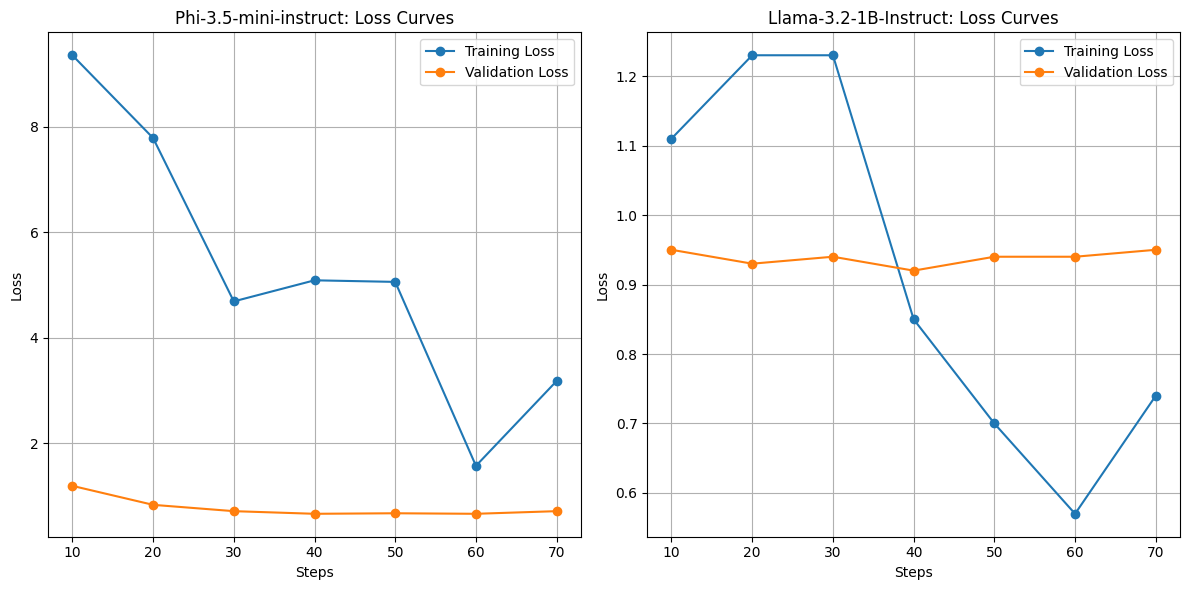

In [ ]:
import matplotlib.pyplot as plt

# Data for Phi-3.5-mini-instruct
phi_steps = [10, 20, 30, 40, 50, 60, 70]
phi_train_loss = [9.36, 7.79, 4.69, 5.09, 5.06, 1.57, 3.18]
phi_val_loss = [1.19, 0.83, 0.71, 0.66, 0.67, 0.66, 0.71]

# Data for Llama-3.2-1B-Instruct
llama_steps = [10, 20, 30, 40, 50, 60, 70]
llama_train_loss = [1.11, 1.23, 1.23, 0.85, 0.70, 0.57, 0.74]
llama_val_loss = [0.95, 0.93, 0.94, 0.92, 0.94, 0.94, 0.95]

# Create a figure for the plots
plt.figure(figsize=(12, 6))

# Plot for Phi-3.5-mini-instruct
plt.subplot(1, 2, 1)
plt.plot(phi_steps, phi_train_loss, label='Training Loss', marker='o')
plt.plot(phi_steps, phi_val_loss, label='Validation Loss', marker='o')
plt.title('Phi-3.5-mini-instruct: Loss Curves')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot for Llama-3.2-1B-Instruct
plt.subplot(1, 2, 2)
plt.plot(llama_steps, llama_train_loss, label='Training Loss', marker='o', color='tab:blue')
plt.plot(llama_steps, llama_val_loss, label='Validation Loss', marker='o', color='tab:orange')
plt.title('Llama-3.2-1B-Instruct: Loss Curves')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Compute ROUGE and BERTSCORE
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from tqdm.auto import tqdm

# Load the merged model and tokenizer
merged_model = AutoModelForCausalLM.from_pretrained("./fine-tuned-merged-model")
tokenizer = AutoTokenizer.from_pretrained("./fine-tuned-model")

# Create a text generation pipeline
generator = pipeline("text-generation", model=merged_model, tokenizer=tokenizer)


# Define a function to extract input text and reference summary
def extract_input_and_reference(example):
    # Extract user message (input text)
    user_message = example["messages"][1]["content"]
    input_text = user_message.replace("Summarise the following text: ", "").strip()

    # Extract assistant message (reference summary)
    assistant_message = example["messages"][2]["content"]
    reference_summary = assistant_message.replace("Sure! Here is the summary:\n", "").strip()

    print("\nReference Summary:")
    print(reference_summary)

    return input_text, reference_summary

# Define a function to compute ROUGE and BERTScore
def compute_metrics(dataset):
    rouge = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    rouge_scores = []
    bert_scores = []

    for example in tqdm(dataset, total=len(dataset)):
        # Extract input text and reference summary
        input_text, reference_summary = extract_input_and_reference(example)

        # Prepare the prompt for inference
        messages = [
            {
                "role": "system",
                "content": "You are a helpful assistant that summarizes earnings call documents. Your task is to perform abstractive summarization on the given text. Pay special attention to performance-related numbers and key metrics. Summarize the text in a few short and concise sentences, focusing on the most important information. Always start your summary with 'Sure! Here is the summary:\n'.",
            },
            {
                "role": "user",
                "content": f"Summarise the following text: {input_text}",
            },
            {
                "role": "assistant",
                "content": "Sure! Here is the summary:\n",
            },
        ]

        # Convert messages to a single string for the model
        prompt = "\n".join([f"{msg['role']}:\n{msg['content']}" for msg in messages])

        # Generate summary
        generated_summary = generator(
            prompt,
            max_new_tokens=512,
            num_beams=1,
            do_sample=False, # Disable sampling, deterministic output
            temperature=0.2,
            top_p=0.95,
        )[0]["generated_text"]

        # Extract the assistant's response from the generated text
        generated_summary = generated_summary.split("Sure! Here is the summary:\n")[-1].strip()

        # Print generated summary
        print("\nGenerated Summary:")
        print(generated_summary)

        # Compute ROUGE scores
        rouge_result = rouge.score(reference_summary, generated_summary)
        rouge_scores.append(rouge_result)

        # Compute BERTScore
        P, R, F1 = bert_score([generated_summary], [reference_summary], lang="en")
        bert_scores.append(F1.mean().item())

    # Aggregate results
    avg_rouge1 = sum([s["rouge1"].fmeasure for s in rouge_scores]) / len(rouge_scores)
    avg_rouge2 = sum([s["rouge2"].fmeasure for s in rouge_scores]) / len(rouge_scores)
    avg_rougeL = sum([s["rougeL"].fmeasure for s in rouge_scores]) / len(rouge_scores)
    avg_bertscore = sum(bert_scores) / len(bert_scores)

    return {
        "avg_rouge1": avg_rouge1,
        "avg_rouge2": avg_rouge2,
        "avg_rougeL": avg_rougeL,
        "avg_bertscore": avg_bertscore,
    }

# Compute metrics on the validation set
print("Evaluating on the validation set...")
valid_metrics = compute_metrics(filtered_eval_dataset)
print(f"Validation Set - Average ROUGE-1: {valid_metrics['avg_rouge1']:.2f}")
print(f"Validation Set - Average ROUGE-2: {valid_metrics['avg_rouge2']:.2f}")
print(f"Validation Set - Average ROUGE-L: {valid_metrics['avg_rougeL']:.2f}")
print(f"Validation Set - Average BERTScore: {valid_metrics['avg_bertscore']:.2f}")

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.
Device set to use cuda:0


Evaluating on the validation set...


  0%|          | 0/16 [00:00<?, ?it/s]


Reference Summary:
abbott sold more than 225 mln covid-19 tests globally in q3.
compname says company sold more than 225 million covid tests globally in third quarter.
compname says co has supply capacity of more than 100 million tests per month.
abbott forecasts $1 billion to $1.4 billion of covid testing-related sales in q4.

Generated Summary:
- Abbott reported strong quarterly results with organic sales growth of 22.4%, led by strong performance across all businesses and $1.9 billion in COVID testing-related sales.
- Excluding COVID testing-related sales, organic sales growth was 12.1% versus last year and 11.7% compared to the third quarter of 2019.
- Adjusted gross margin ratio was 58.8% of sales, adjusted R&D investment was 6% of sales, and adjusted SG&A expense was 25% of sales.
- The revised full year forecast reflects a modestly higher tax rate due to a shift in the mix of business and geographic income.
- Abbott forecasts $1 billion to $1.4 billion of COVID testing-related 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
second quarter sales of $404 million, down 28% from the prior year reflecting the impact of covid-19.
qtrly adjusted diluted earnings per share from continuing operations of $0.31, which excludes impact of cares act support, other items.
q2 adjusted earnings per share $0.31 from continuing operations excluding items.
q2 sales $404 million versus refinitiv ibes estimate of $409.4 million.

Generated Summary:
- Sales decreased 28% year-over-year to $404 million due to the pandemic's impact on commercial passenger flying activity.
- Aviation Services sales were up 5.9% sequentially, while Expeditionary Services sales were down 50%.
- Government and defense business increased 19% year-over-year, reflecting strong performance on existing contracts.
- Gross profit margin increased to 17.2% from 15.3% in the prior year quarter, driven by the CARES Act payroll support.
- SG&A expenses were $38 million or 9.4% of sales, down from the prior year quarter.
- Cash flow provided 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname posts q3 adjusted earnings per share $0.37 from continuing operations.
q3 adjusted earnings per share $0.37 from continuing operations excluding items.
q3 sales $410 million versus refinitiv ibes estimate of $412.4 million.
compname says q3 sales down 26% from prior year reflecting continued impact of covid-19.

Generated Summary:
- Sales decreased 26% year-over-year to $410 million, with commercial sales down 42% and government/defense sales up 4%.
- Adjusted diluted earnings per share from continuing operations decreased 45% to $0.37.
- Gross margin improved sequentially from 13.9% to 16.1%, and operating margin improved from 4% to 5%.
- The company was cash flow positive in the quarter, with $18 million generated from operating activities.
- The company secured new contracts with the US Air Force and the Navy, and began operations on a previously announced Honeywell 737 MAX EBAS contract.
- Sales were down 25.8% year-over-year due to reduced commercial p

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
qtrly earnings per share from continuing operations $2.05; qtrly adjusted earnings per share from continuing operations $2.38.
qtrly revenue $5.40 billion, down 1%.
qtrly same-store new vehicle gross profit per vehicle retailed was $2,535, up 56%.
qtrly same-store used vehicle gross profit per vehicle retailed was $1,994, up 43%.
qtrly same-store customer financial services gross profit per vehicle retailed was $2,154, up 11%.
increased share repurchase authorization to $500 million.
plans to build over 100 autonation usa pre-owned vehicle stores, with over 50 completed by end of 2025.
qtrly same-store total variable gross profit per vehicle retailed was up $966.
qtrly adjusted sg&a as a percentage of gross profit was 64.4%, up 800 basis points.

Generated Summary:
- AutoNation reported record-breaking third-quarter results, with adjusted earnings per share from continuing operations at $2.38, a 102% increase compared to last year.
- The company saw strong demand an

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname reports q4 earnings per share of $0.89.
q4 earnings per share $0.89.

Generated Summary:
- ARMOUR's Q4 book value increased to $12.32 per share, up $0.58 from Q3 2020.
- Q4 comprehensive income was $60.2 million or $0.89 per share.
- Dividends paid in Q4 totaled $19.6 million.
- ARMOUR's portfolio duration increased to 0.76, with a significant portion in key rate buckets.
- The company's implied leverage ratio decreased to 6.9, providing additional dry powder for market opportunities.
- ARMOUR's dividend policy is based on the medium-term outlook on the business.
- The company will continue to shape its portfolio to protect book value and not reach for yield at the expense of higher risk.
- The company expects the Fed's presence in the market to persist at least for the first half of 2021.
- The company's convexity profile remains more favorable than newly issued MBS due to early investment in specified pools.
- ARMOUR monitors its hedge book and manages th

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname reports q2 earnings per share $0.95.
q2 adjusted earnings per share $2.14.
q2 earnings per share $0.95.
sees q3 adjusted earnings per share $1.90 to $2.00.

Generated Summary:
- Earnings per share for the quarter were $0.95, up from $0.94 in the prior year.
- Adjusted earnings per share increased to $2.14, up from $1.33 in 2020.
- Net sales were up 34% due to increased volumes, favorable foreign currency translation, and higher material costs.
- Segment income improved to $395 million, up from $250 million, due to higher sales volumes and recovery in COVID-affected locations.
- Third quarter 2021 adjusted earnings guidance is between $1.90 and $2 per share, assuming the sale of the Europe Tinplate business closes at the end of August.
- The expected adjusted tax rate for the full year remains at 24% to 25%.
- Demand remained strong across all product lines and geographies, leading to record earnings.
- Average segment income from continuing operations over 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
qtrly net premiums earned of $133.9 million, down 20% year-over-year.

Generated Summary:
- The call features CEO Kathy Antonello and CFO Mike Paquette.
- The company's performance during the COVID-19 pandemic has been strong, with a record number of policies in force.
- The renewal premium decreased by 11% year-over-year, but the policy retention rate remained strong at 94%.
- The company's net premiums earned decreased by 20% due to lower written premiums and reduced final audit accruals.
- Losses and loss adjustment expenses decreased by 33%, and commission expenses decreased by 21%.
- The company's net investment income decreased by 8% due to lower interest rates.
- The company repurchased $10 million of its common stock, with remaining authority at just under $19 million.
- The Cerity operating segment is gaining traction, writing $0.5 million in premium in 2021.
- The company's balance sheet and capital position are strong, supporting its initiatives for the u

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
now expect 2021 adjusted earnings per share to be between $8.25 and $8.75.
expect 2021 free cash flow to approach $1.1 billion.

Generated Summary:
- The company reported 20% higher adjusted earnings per share over 2019 and 5% over a strong first quarter in 2020.
- Record free cash flow of $125 million was achieved in the first quarter, up from a strong performance a year ago.
- The company made significant progress with circular economy efforts, including a large plastic-to-plastic molecular recycling facility in Tennessee.
- Despite headwinds such as maintenance turnaround, supplier reliability, and auto production slowdown, the company expects sequential EPS increase and strong market growth.
- The company expects adjusted earnings per share to be between $8.25 and $8.75 for the full year of 2021, with free cash flow approaching $1.1 billion.
- The company remains committed to innovation, investment in specialty portfolio, and sustainable value creation for stake

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname reports q3 ffo per share $1.85 excluding items.
q3 ffo per share $1.85 excluding items.
sees 2021 ffo per share to be $6.75 - $6.85.
extra space storage - increased same-store revenue by 18.4% and same-store net operating income by 27.8% in quarter compared to same period in 2020.

Generated Summary:
- The company celebrated the addition of store #2000 and strong operating results, marking the strongest in its history.
- Same-store occupancy reached a new high at over 97%, with strong pricing power due to high occupancy.
- Rates to new customers were 43% higher than 2020 and 41% greater than 2019.
- Increased late fees contributed to revenue growth, offsetting higher discounts due to higher street rates.
- Same-store revenue growth was 18.4%, and same-store NOI growth was 27.8%.
- External growth initiatives resulted in steady returns, with FFO growth of 41.2%.
- The company acquired 96 stores, with a focus on FFO per share accretion.
- The company raised i

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
fabrinet q1 earnings per share $0.69.
q1 non-gaap earnings per share $0.86.
q1 gaap earnings per share $0.69.
sees q2 revenue $408 million to $416 million.
q1 revenue $399.3 million versus refinitiv ibes estimate of $390.3 million.
sees q2 2020 non-gaap earnings per share $0.91 to $0.94.
sees q2 2020 gaap earnings per share $0.74 to $0.77.

Generated Summary:
- Revenue in Q1 was $399 million, with non-GAAP net income at $0.86 per share.
- Optical communications revenue was $302 million, up from Q4, representing 76% of total revenue.
- Datacom revenue decreased to $73 million, a 15% decline from Q4.
- Non-GAAP gross margin improved to 12% in Q1.
- Operating cash flow was $2.6 million, with a free cash flow outflow of $3.7 million.
- Guidance for Q2 is revenue between $408 million and $416 million, with non-GAAP net income per share in the range of $0.91 to $0.94.
- The company is optimistic about long-term prospects and has achieved milestones towards establishing a 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
qtrly earnings per share $0.17.
qtrly adjusted earnings per share $0.37.

Generated Summary:
- Sales totaled $367 million, a decrease of 14% from the previous quarter.
- Acquisitions added two percentage points of growth, while currency translation rates decreased sales by approximately one percentage point.
- Net earnings totaled $29 million for the quarter, including $30 million related to impairment charges from selling the Alco business.
- Alco operations contributed $7 million of sales and $2 million of operating losses year-to-date.
- Gross margin rate was 49.8%, three percentage points below the previous quarter.
- Operating expenses decreased by $12 million, excluding the effect of impairment.
- The reported income tax rate was 31%, primarily due to nondeductible impairment charges.
- After adjusting for impairment, tax rate was 19%.
- Cash flows from operations totaled $143 million, lower than the previous year.
- Capital expenditures totaled $33 million, i

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname reports q4 earnings per share of $1.05.
compname reports fourth quarter earnings per share of $1.05 and full year earnings per share of $0.45.
q4 revenue $106.7 million versus refinitiv ibes estimate of $86.9 million.
board authorized up to $60 million of purchases of shares and share equivalents in 2020.
qtrly earnings per share $1.05.

Generated Summary:
- Patrick Suehnholz, head of investor relations at Greenhill, discussed the company's performance, highlighting a strong finish to the year with respectable full-year results on top and bottom line.
- Revenue for the full year was down 14%, with a decline in advisory revenue in Europe offset by increases in North America, Australia, and the rest of the world.
- Restructuring advisory revenue improved significantly, while capital advisory team performance fell short of the prior year's record revenue level.
- Non-compensation operating expenses were $3.7 million higher than the same period last year due to

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
live nation entertainment - believes current level of liquidity provides ability to fund operations until expected return of concerts in summer of 2021.

Generated Summary:
- Live Nation focused on improving its business amidst the challenges of 2020.
- Key initiatives included reducing cost structure by $200 million, building new revenue streams, advancing technology, and strengthening the balance sheet.
- Despite the challenges, the company remains optimistic about future opportunities, with strong demand for concerts and a substantial surplus in savings indicating potential consumer spending.
- The company's Q4 AOI loss was $244 million, with positive contribution margin from operations, sponsorship, artist management, and merchandise.
- Free cash and liquidity were strong, with $643 million in free cash and $2 billion in available liquidity.
- The global refund rate for rescheduled concerts remained at 17%, and 63% of fans retained their tickets for next year's 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
q4 adjusted loss per share $0.07.
q4 revenue $236 million versus refinitiv ibes estimate of $237.6 million.
qtrly revenue decreased by 19.5% due to seasonally lower activity levels and a smaller active fleet of pressure pumping equipment.
rpc - during q4, continued to execute downsizing plans, including closing facilities, scrapping equipment & reducing headcount.
rpc -in connection with preparation of q4 financial statements, additional impairment and other charges of $10.6 million in technical services segment.

Generated Summary:
- Non-GAAP measures used include adjusted net loss, adjusted net income, adjusted loss per share, adjusted earnings per share, adjusted operating loss, adjusted operating profit, EBITDA, and adjusted EBITDA.
- The company executed downsizing plans, reducing headcount by 21% since Q2.
- Fourth-quarter revenues decreased to $236 million due to lower activity levels, lower pricing, and smaller fleet.
- Adjusted operating loss was $17.3 mill

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname reports q3 loss per share $0.03.
q3 loss per share $0.03.

Generated Summary:
- SunCoke's third-quarter performance was impacted by lower volumes due to customer turndowns, resulting in a loss of $0.03 per share compared to a loss of $1.81 per share in the same quarter of the previous year.
- Adjusted EBITDA decreased by $11.8 million, mainly due to lower volumes and pricing in coke operations.
- The company extended the Haverhill II contract with AK Steel for an additional two years, illustrating the strength of its customer relationships.
- SunCoke is well-positioned to enter the foundry coke market in 2021 with a high-quality product.
- The company's cash balance at the end of the quarter was $86 million, with cash flow from operations generating $74.5 million and capex of $16.5 million.
- SunCoke paid a $0.06 per share dividend, which was a use of cash of $5 million.
- The company's gross leverage was 3.37 times, and its net leverage was 2.98 times, wit

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
q3 adjusted non-gaap earnings per share $3.57.
expects to continue to fund its operations fully within operating cash flow.
forecasts to be in a positive net cash position with no outstanding balance on its credit facility by end of 2021.

Generated Summary:
- Brandon Day, Whiting's investor relations Manager, and key executives will answer Q&A during the earnings call.
- The company's net income for Q3 2021 was $198 million, up from a loss in the previous quarter.
- Adjusted net income was $142 million, due to mark-to-market of hedging instruments and gain on sale properties.
- Adjusted EBITDAX was $201 million, due to better commodity prices.
- Oil production decreased from the previous quarter, but oil differentials have narrowed due to increased basin production.
- The company invested $67 million in capex during Q3 2021.
- Lease operating expenses were $57 million, with less workovers during the quarter.
- General and administrative expenses were $12 million.
-

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Set - Average ROUGE-1: 0.15
Validation Set - Average ROUGE-2: 0.06
Validation Set - Average ROUGE-L: 0.10
Validation Set - Average BERTScore: 0.83


In [ ]:
# Compute metrics on the test set
print("\nEvaluating on the test set...")
test_metrics = compute_metrics(filtered_test_dataset)
print(f"Test Set - Average ROUGE-1: {test_metrics['avg_rouge1']:.2f}")
print(f"Test Set - Average ROUGE-2: {test_metrics['avg_rouge2']:.2f}")
print(f"Test Set - Average ROUGE-L: {test_metrics['avg_rougeL']:.2f}")
print(f"Test Set - Average BERTScore: {test_metrics['avg_bertscore']:.2f}")


Evaluating on the test set...


  0%|          | 0/24 [00:00<?, ?it/s]


Reference Summary:
compname reports q1 sales of $455 mln.
q1 adjusted earnings per share $0.52 from continuing operations.
q1 sales $455 million versus refinitiv ibes estimate of $438.4 million.

Generated Summary:
- The company reported a 14% increase in sales from $401 million to $455 million, with adjusted diluted earnings per share rising from $0.17 to $0.52.
- Sales to commercial customers increased by 52%, while sales to government and defense customers decreased by 17%.
- The company's operating margin was 5.5% for the quarter, up from 2.5% last year and 5.2% in Q1.
- The company generated $18 million from operating activities from continuing operations and reduced the usage of its accounts receivable financing program.
- The company announced new business wins, including an exclusive agreement with Arkwin and a contract with the Department of Energy.
- The company's sales in Afghanistan were $67 million, with high single-digit operating margins.
- The company expects overall Q

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname reports q2 earnings per share of $0.42.
q2 earnings per share $0.42.

Generated Summary:
- ARI originated five first mortgage loans totaling $825 million in Q2, with year-to0-date total originations at $1.4 billion.
- Real Capital Analytics reported a 167% increase in second quarter volume versus last year.
- ARI's European lending platform is performing well, with 70% of transactions completed in Europe.
- Three loans totaling $260 million were repaid during the quarter.
- ARI completed an $800 million debut offering of senior secured notes at 4.5/8%.
- ARI's CECL reserve remained relatively unchanged quarter-over-quarter, with $20 million reversed against the Fulton Street loan.
- ARI's debt-to-equity ratio increased to 2.3 times at quarter end.
- ARI exchanged its $169 million, 8% Series B preferred stock for a 7.1/4% Series B1 preferred stock, reducing its cost by 75 basis points per annum.

user:
Can you provide a more detailed summary focusing on the 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname reports q3 earnings per share of $0.38.
q3 earnings per share $0.38.

Generated Summary:
- Commercial real estate market is recovering at a measured pace, with property type and geographic winners and challenges.
- Real estate investment and financing activity recovered quickly, supported by low-interest rates and significant fund flows.
- Commercial real estate lending surpassed 2019 levels, with ARI completing $1.5 billion of new transactions and expecting to approach pre-pandemic levels.
- ARI's European loan portfolio represents 40% of the portfolio, with similar transaction types and quality of equity sponsorship as in the U.S.
- ARI's loan portfolio had a weighted average unlevered yield of 5.2% and a remaining term of just under three years.
- ARI made a $180 million first mortgage and $113 million of add-on fundings for previously closed loans.
- ARI is in compliance with all covenants and maintains strong liquidity with $600 million total liquidity

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
badger meter q3 earnings per share $0.54.
q3 earnings per share $0.54.
q3 sales $128.7 million versus refinitiv ibes estimate of $127 million.
anticipate component shortages and lengthened lead times will ease over time, but assume they will persist well into 2022.

Generated Summary:
- Total sales for the third quarter were $128.7 million, a 13.3% increase over the same period last year.
- Excluding the s::can and ATI acquisitions, core utility water revenues increased 1.7% year-over-year.
- Gross margins improved to 39.8% from 39.6%, despite widespread inflation and supply chain challenges.
- Operating profit margin was 15.1%, compared to a record 17.2% in the prior year quarter.
- Earnings per share increased to $0.54, up from $0.51 in the prior year.
- Free cash flow was $13.9 million, lower than the prior year due to higher working capital.
- Backlog and strong order momentum confirm the underlying market demand for the company's solutions.
- Supply chain disru

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
central pacific financial q4 earnings per share $0.50.
q4 earnings per share $0.50.
central pacific financial - net interest income for fourth quarter of 2019 was $47.9 million, compared to $44.7 million in the year-ago quarter.

Generated Summary:
- The company reported strong financial performance in Q4 2019 and full 2019 year, with solid loan and deposit growth, strong asset quality, and solid capital ratios.
- Net interest income, net interest margin, non-interest income, and efficiency ratio improved year-over-year.
- The company repurchased 165,700 shares of CPF stock during Q4 and returned $48.5 million in capital to shareholders in 2019.
- Total assets surpassed $6 billion, with loan growth of $371 million and deposit growth of $243 million.
- The company launched a new website and implemented a new loan origination system, while making progress on branch and ATM modernization.
- The Hawaii economy is performing well, with visitor arrivals and construction a

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname reports q4 ffo per share $1.38.
q4 ffo per share $1.38.
estimated ffo per share attributable to common stockholders for 2021 is estimated to be in the range of $5.63 to $5.73.

Generated Summary:
- The company's fourth quarter and full year results were strong, demonstrating the resiliency of the portfolio and the industrial market.
- Funds From Operations (FFO) per share for the fourth quarter exceeded guidance at $1.38, up 8.7% from the previous year.
- The company ended the year at $5.38 per share in FFO, surpassing pre-COVID forecasts.
- Occupancy remained high, with quarterly averages at 96.9% and year-end projections at 98%.
- Releasing spreads were strong, with GAAP at 15.4% and cash at 7.9%.
- Same-store NOI rose 2.2% for the quarter and 3.2% for the year.
- The company acquired several new sites and value-added investments, with no developments in Houston.
- The company's financial strength and flexibility were maintained through equity issuance an

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
q2 adjusted ffo per share $0.47.
approved about 540 resident applications for deferral of rent due to covid related financial hardship in quarter.

Generated Summary:
- Second quarter results show continued strength of the business, with a 4.6% increase in rental revenue for MH properties.
- RV revenue grew by 4.7% in the second quarter, with a significant increase in reservation activity and revenue in June.
- Occupancy at MH properties increased by 103 sites since December, with a decrease in renters by 53.
- Core RV resort-based rental income from annuals increased by 4.7% for the second quarter and 6.1% year-to0-date.
- Membership dues revenue increased by 3% compared to the prior year, with a decrease in membership sales due to COVID-19.
- Core property operating revenues increased by 60 basis points and core property operating expenses increased by 10 basis points, resulting in an increase in core NOI before property management of 1%.
- Property management and

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname reports q1 earnings per share of $0.09.
q1 revenue rose 3 percent to $68.9 million.
q1 earnings per share $0.09.

Generated Summary:
- Patrick Suehnholz, Head of Investor Relations at Greenhill, joined Scott Bok, CEO, for an earnings call.
- The firm reported a revenue of $68.9 million, an operating profit of $7.2 million, and net income per share of $0.09 for the first quarter.
- Revenue was 3% higher than the previous year, and the company saw a significant increase in M&A activity, particularly in the U.S.
- The company is focused on deleveraging and share repurchases to enhance shareholder value.
- Compensation costs were lower than the previous year, but the compensation ratio was higher than the target range.
- The company ended the quarter with $87.9 million of cash and $326.9 million of debt, with another $20 million of debt paid down since quarter end.
- The company declared a $0.05 quarterly dividend and bought back just under a million shares and

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
q2 sales $1.183 billion versus refinitiv ibes estimate of $1.12 billion.

Generated Summary:
- The company's net sales increased by 25.6% to $1.183 billion, despite a 9% reduction in the global store fleet.
- Adjusted SG&A expenses decreased to 31.5% of sales from 35.8% in the same quarter last year.
- The company ended the quarter with cash and restricted cash of $1.775 billion, up from $1.651 billion at the end of the second quarter last year.
- The company raised $1.1 billion through the issuance of 5 million shares of common stock under an ATM.
- Total shares outstanding are now approximately 75.9 million.
- Capital expenditures for the quarter were $13.5 million, bringing year-to-date capex investments to 28.2 million.
- Cash flow from operations was an outflow of $11.5 million, compared to an inflow of $192.8 million during the same period last year.
- The company is not providing formal guidance at this time.
user:
What were the key steps taken by the company

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
qtrly diluted loss per share $1.94.

Generated Summary:
- GameStop underwent significant transformation in 2021, focusing on customer-obsessed technology, competitive pricing, and wider offerings.
- The company installed a new management team, refreshed the Board, reduced director compensation, ended relationships with costly external consultants, and hired new individuals with e-commerce and technology experience.
- GameStop raised approximately $1.67 billion in capital, expanded its product catalog, invested in fulfillment networks, and revamped its systems and tech stack.
- The company invested in U.S.-based customer service, established a new facility in South Florida, and invested in blockchain gaming and cryptocurrency.
- GameStop's net sales were $2.25 billion for the quarter, compared to $2.12 billion in the prior year, marking the first quarter in which growth surpassed pre-pandemic levels.
- The company ended the year with cash and cash equivalents of over

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname announces quarterly net income per diluted share of $0.51.
idt corp - qtrly net income per diluted share of $0.51.
idt corp - qtrly revenue of $340 million.

Generated Summary:
- IDT reported strong quarterly results with significant year-over-year increases in consolidated revenue, income from operations, and EPS.
- Consolidated revenue rose by $16 million to $340 million, marking the third consecutive quarter of growth and the sixth consecutive quarter of growth excluding direct cost of revenue.
- Income from operations increased by $11.6 million to $12.9 million, driven by a $9 million increase in revenue less direct cost of revenue.
- Fully diluted EPS rose to $0.51 from $0.04 in the year-ago quarter.
- The Fintech segment saw revenue growth of over 150% year over year, led by payment processing services and digital out-of-home advertising sales.
- The net2phone-UCaaS segment saw subscription revenue climb 36% to $10.1 million, with growth in all market

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
q2 revenue $821 million versus refinitiv ibes estimate of $660.5 million.
average assets under management (aum) for q2 of 2021 was $276 billion.
qtrly financial advisory operating revenue was $471 million, 61% higher than q2 of 2020.
aum as of june 30, 2021, was $277 billion.

Generated Summary:
- Alexandra Deignan is the Head of Investor Relations and Corporate Sustainability at Lazard.
- The company reported record operating revenue for the second quarter and first half of 2021, with a 51% increase in second quarter revenue and a 33% increase in first half revenue.
- Financial advisory revenue increased by 61% in the second quarter, driven by strong activity across sectors, market cap, and regions.
- Asset Management operating revenue reached an all-time high for the quarter and first half of the year, with a 40% increase in second quarter revenue.
- Average AUM for the second quarter reached a record high of $276 billion, 32% higher than a year ago.
- The company

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
q3 earnings per share $1.61.
q3 revenue $161.9 million versus refinitiv ibes estimate of $146.4 million.
expect raw material inflation and supply chain challenges to persist through balance of our fiscal year.
remain optimistic about outlook for co's infrastructure business.

Generated Summary:
- Total revenues for the third quarter of fiscal 2021 increased by 32% to $161.9 million compared to the same quarter last year.
- Net earnings increased to $1.61 per diluted share from $0.93 per diluted share.
- Irrigation segment revenues increased by 47% to $140.2 million, with higher equipment sales volume and average selling prices.
- International irrigation revenues increased by 62% to $52.8 million, due to higher equipment sales volumes and favorable foreign currency translation.
- Irrigation segment operating income increased by 55% to $23.9 million, with improved margins supported by higher equipment sales volume.
- Infrastructure segment revenues decreased by 21% t

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname reports q4 earnings per share $0.59.
q4 earnings per share $0.59.

Generated Summary:
- Sales increased by 4.2% due to higher year-over-year production in the ethanol segment and increased distillers grain pricing.
- Gross profit for the ethanol and by-products segment increased from $8.1 million to $8.3 million due to improved distillers and corn oil pricing.
- The refined coal segment had a similar fourth quarter loss of $1.4 million for this year versus a $1.5 million for the prior year.
- SG&A decreased from $5.6 million to $4.4 million due to lower ethanol freight charges.
- The company recorded income from its unconsolidated equity investment of $332,000 for the fourth quarter of this year versus $1 million in the prior year.
- The tax benefit decreased from $3.4 million to $1.8 million, with the refined coal segment contributing a benefit of $1.7 million.
- Net income for the fourth quarter of fiscal 2020 was $3.5 million compared to $4.4 million in 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
simon property sees fy ffo per share $9.70 to $9.80.
sees fy ffo per share $9.70 to $9.80.
q1 ffo per share $2.48.
qtrly net income attributable to common stockholders was $1.36 per diluted share.u.s. malls and premium outlets operating statistics occupancy was 90.8% at march 31, 2021.
will declare a common stock cash dividend for q2 of 2021 on or before june 30, 2021.

Generated Summary:
- Brian McDade, CFO, and Adam Reuille, CSO, were present on the call.
- The company reported improved profitability and cash flow in the first quarter, with funds from operation at $934 million or $2.48 per share.
- FFO increased by $150 million or $0.31 per share compared to the previous quarter.
- International operations were affected by governmental closure orders and capacity restrictions, resulting in a negative impact of $0.08 per share.
- The company generated $875 million in cash from operations, an increase of 18% compared to the prior-year period.
- Mall and outlet occup

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
q2 adjusted non-gaap earnings per share $1.99.
reiterates fiscal 2022 outlook.

Generated Summary:
- STERIS' Q2 revenue increased by 12% in constant currency, driven by organic volume growth and price increases.
- Gross margin improved by 120 basis points to 46.2%, despite higher material and labor costs.
- EBIT margin increased by 80 basis points to 23.3%, but operating expenses limited further growth.
- Net income rose to $200.3 million, with earnings per share at $1.99.
- The company's leverage ratio is now below 2.8 times, and cash totaled $383.5 million at the end of the quarter.
- Capital expenditures were $133.4 million, with depreciation and amortization at $201.7 million.
- Free cash flow for the first half was $135.8 million, a decline due to acquisition costs and higher capital spending.
- Organic growth remained strong in AST, Healthcare, Life Sciences, and Dental segments.
- Procedure volumes in the U.S. have held steady, and the company is optimistic a

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
sees q2 adjusted earnings per share $2.85 to $2.95.
sees fy adjusted earnings per share $12.00 to $12.20 excluding items.
expect to complete acquisition of flir on may 14, 2021.

Generated Summary:
- Teledyne achieved its best first-quarter sales, earnings, operating margin, and cash flow in history, despite $39 million of expenses related to the pending FLIR acquisition.
- Excluding non-recurring charges, earnings increased 39.2% year-over-year, with operating margin up by 426 basis points and free cash flow nearly doubling.
- Year-over-year sales increased in nearly every major business category, with the strongest growth in Digital Imaging.
- Teledyne received all-time record orders, resulting in a quarter-end backlog of approximately $1.8 billion.
- The company expects a 6% total organic sales growth in 2021, led by a 10% growth in Digital Imaging excluding FLIR.
- Teledyne expects immediate pre-tax annual synergies greater than $40 million and earnings per shar

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
sees fy earnings per share $11.25 to $11.45.
sees q1 earnings per share $2.55 to $2.60.
issuing full year 2021 diluted earnings per share outlook of $11.25 to $11.45.

Generated Summary:
- The company concluded 2020 with the best earnings, operating margin, and cash flow in its history.
- Fourth quarter earnings increased by 13.7%, operating margin increased by 173 basis points, and free cash flow increased by 50.7%.
- Full year 2020 saw a slight increase in GAAP operating margin and a significant increase in free cash flow, despite $33 million in nonrecurring charges, record negative GDP in Q2, and challenges faced by manufacturures during the COVID-19 pandemic.
- The company entered 2021 with improved demand across most businesses, record orders in Q4, and a backlog of $1.7 billion.
- Organic growth for the total company is expected to be between 5% and 6% for 2021, with a cautious outlook for Q1 due to flat revenue.
- The pending acquisition of FLIR is seen as a 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
q4 adjusted earnings per share $0.08 per share.

Generated Summary:
- The company reported a consolidated adjusted profit of $8 million or $0.08 per share in Q4, up from 95,000 in the prior quarter.
- Total adjusted EBITDA increased to 182 million, up from 165 million in the previous quarter.
- FY 2021 results included Teekay LNG, with consolidated net income and EBITDA decreasing due to a strong tanker market in the first half of 2020.
- The sale of Teekay LNG interest to Stonepeak brought in approximately 641 million, reducing high-cost debt and leaving Teekay Parent largely debt-free with a net cash position of over 300 million.
- The company expanded its asset-light marine services business in Australia and is planning for the decommissioning of its remaining FPSOs.
- Teekay Tankers' investment increased its value to $125 million or $1.23 per Teekay Corp share.
- The company's net cash position is over $300 million, providing financial strength and flexibility f

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
q1 adjusted non-gaap earnings per share $0.70.
q1 earnings per share $0.75.
full-year adjusted earnings per share outlook raised by $0.10.
now expects 2021 earnings per share from continuing operations to be in a range of $2.76 to $3.00, or $2.80 to $3.00 on an adjusted basis.
qtrly revenues at textron aviation of $865 million were down $7 million from q1 of 2020.
bell backlog at end of q1 was $5.2 billion.
qtrly bell revenues were $846 million, up $23 million from last year.

Generated Summary:
- Textron Aviation revenues were down $7 million from last year, but backlog increased to $2.1 billion.
- Textron Systems revenues were flat, but backlog increased to $2.4 billion.
- Industrial revenues were up $85 million, with backlog at $2.4 billion.
- Adjusted net income for the first quarter was $0.70 per share, up from $0.35 per share in the first quarter of 2020.
- Manufacturing cash flow before pension contributions was $71 million, up $501 million from last year's f

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
universal health services increases 2021 fy earnings guidance.

Generated Summary:
- The company's after-tax earnings increased by approximately $30 million in Q2 2021, exceeding internal forecasts.
- COVID-19 patient numbers declined, leading to a recovery in non-COVID patient volumes, driving robust operating results.
- Cash generated from operating activities was $119 million in Q2 2021, down due to early repayment of Medicare payments.
- The company resumed its share repurchase program, authorizing a $1.0 billion increase, with $1.2 billion remaining.
- Full year earnings guidance was raised, predicting a 6%-8% increase in adjusted EBITDA.
- Recent surges in COVID-19 patients have made the impact on non-COVID volumes and labor shortages uncertain.

user:
What was the impact of the early repayment of Medicare accelerated payments on the company's cash generated from operating activities?
assistant:
The early repayment of $695 million of Medicare accelerated payme

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
compname reports q3 gaap earnings per share of $0.64.
q3 gaap earnings per share $0.64.
qtrly non-gaap adjusted earnings per share of $0.63.3q21 direct premiums earned up 15.0% driven by primary rate increases earning-in.

Generated Summary:
- Direct premiums earned grew by 15% in Q3, driven by primary rate increases in Florida.
- Business expenses were lower due to expense management controls.
- Adjusted operating income showed a 16.4% annualized return on average equity.
- Adjusted EPS was $0.64 on a GAAP basis and $0.63 on a non-GAAP basis.
- The combined ratio improved by 36.1 points to 98.6%.
- The expense ratio improved by 5.2 points for the quarter.
- Net investment income decreased by 38.6% to $2.8 million.
- The company repurchased approximately 101,000 shares at an aggregate cost of $1.4 million.
- Guidance for 2021 remains unchanged, with expected EPS between $2.75 and $3 and a return on average equity between 17% and 19%.

user:
What were the key drivers

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
q4 gaap loss per share $0.57.
qtrly adjusted loss per share $0.84.
initiating fy21 guidance: gaap and non-gaap adjusted earnings per share of $2.75 - $3.00.

Generated Summary:
- The company ended the year with $1.5 billion in premiums in force despite record weather events in 2020, with over 10,000 claims from named storms and other PCS events.
- The company increased primary rates in Florida by 20% for the full year, including 7% in the 4th quarter for reinsurance costs.
- The company's direct premiums written grew by 21.9% in Q4 and 7% for the full year, driven by rate increases and increased volume.
- The combined ratio decreased 18.9 points for the quarter to 124% but increased 9.7 points for the full year to 113.6%.
- Net investment income decreased due to lower yields on investments, but realized gains were achieved from increased market prices on available for sale debt investments.
- The company repurchased approximately 193,000 shares in Q4 and 1.6 million

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Reference Summary:
watsco earnings per share jumps 64% to $3.71 in q2.
watsco earnings per share jumps 64% to $3.71 setting records for sales, operating profit, operating margin and net income.
q2 earnings per share $3.71.
q2 revenue $1.85 billion versus refinitiv ibes estimate of $1.68 billion.
targeted operating cash flow to exceed net income in 2021.

Generated Summary:
- Watsco's second quarter saw record-breaking performance with a 64% increase in earnings per share to $3.71 and a 66% increase in net income.
- Sales grew by 36% to a record $1.85 billion, and gross profits increased by 50% with a 220 basis point expansion in gross margins.
- Operating income rose by $88 million or 68%, reaching $217 million, and operating margins expanded to a record 11.7%.
- The company added two new companies, TEC and Acme, to its portfolio.
- Watsco's technology continues to gain traction, with growth rates among active users outpacing nonusers and lower attrition rates.
- The company's balance

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Set - Average ROUGE-1: 0.11
Test Set - Average ROUGE-2: 0.04
Test Set - Average ROUGE-L: 0.08
Test Set - Average BERTScore: 0.82
